
# Loading GDrive options

Here you need to modfy the code in order to mount your own google drive account an access to the `Common/NeuralNetwork` folder




In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/Othercomputers/Il mio PC/Dsktp_Gdrive/NeuralNet/Common/Neural_Network

Mounted at /gdrive
/gdrive/Othercomputers/Il mio PC/Dsktp_Gdrive/NeuralNet/Common/Neural_Network


# KERAS MODEL

In [7]:
# Fix randomness, hide warnings and load modules and libraries
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time

2.15.0


# Load data

In [8]:
# Load the Iris dataset into a variable 'data'
data = load_iris()
iris_dataset = pd.DataFrame(data.data, columns=data.feature_names)

target = data.target
unique, count = np.unique(target, return_counts=True)

# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    iris_dataset,
    target,
    test_size = 30,
    random_state = seed,
    stratify = target
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = 30,
    random_state = seed,
    stratify = y_train_val
)

max_df = X_train.max()
min_df = X_train.min()

# Normalise the dataset splits in the range [0,1]
X_train = (X_train - min_df)/(max_df - min_df)
X_val = (X_val - min_df)/(max_df - min_df)
X_test = (X_test - min_df)/(max_df - min_df)

# Transform labels via one-hot encoding
y_train = tfk.utils.to_categorical(y_train, num_classes=len(unique))
y_val = tfk.utils.to_categorical(y_val, num_classes=len(unique))
y_test = tfk.utils.to_categorical(y_test, num_classes=len(unique))

input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

#define parameters
batch_size = 16
epochs = 100

# Build the model

In [9]:
def build_model(
    input_shape,
    output_shape,
    seed=seed
):

    # Fix randomness
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    hidden_layer = tfkl.Dense(units=128, name='Hidden')(input_layer)
    hidden_activation = tfkl.Activation('relu', name='HiddenActivation')(hidden_layer)

    output_layer = tfkl.Dense(units=output_shape, name='Output')(hidden_activation)
    output_activation = tfkl.Activation('softmax', name='Softmax')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='Feedforward')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    learning_rate = 0.01
    optimizer = tfk.optimizers.SGD(learning_rate)
    metrics = ['Accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

    model = build_model(input_shape, output_shape)



# Trein the model

In [10]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)
start_time = time.time()
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val)
).history

test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)

test_gt = np.argmax(y_test, axis=-1)

test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'\n\nAccuracy score over the test set: {round(test_accuracy, 4)}')
end_time = time.time()
elapsed_time = end_time - start_time

print("\n\nTotal time spent:", elapsed_time, "s")


Model: "Feedforward"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 4)]               0         
                                                                 
 Hidden (Dense)              (None, 128)               640       
                                                                 
 HiddenActivation (Activati  (None, 128)               0         
 on)                                                             
                                                                 
 Output (Dense)              (None, 3)                 387       
                                                                 
 Softmax (Activation)        (None, 3)                 0         
                                                                 
Total params: 1027 (4.01 KB)
Trainable params: 1027 (4.01 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

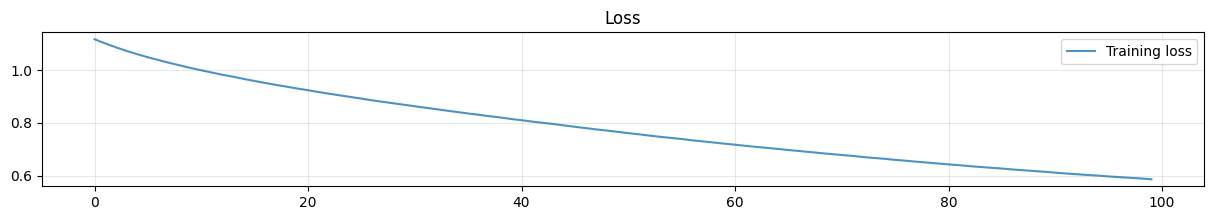

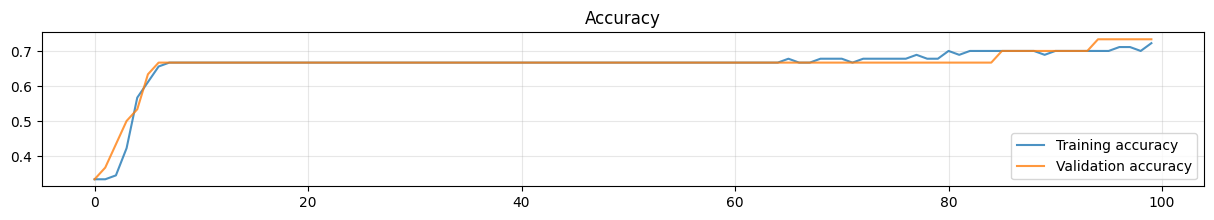

In [11]:
# Create and display plots for training and validation loss
plt.figure(figsize=(15,2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
#plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Create and display plots for training and validation accuracy
plt.figure(figsize=(15,2))
plt.plot(history['Accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_Accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# AMSC NEURAL NETWORK MODEL

### Compile the code

In [12]:
!g++ -O3 -std=c++17 -I ../include -march=native -ffast-math amsc_nnet.cpp ../src/irisLoader.cpp ../src/network_functions.cpp ../src/ActivationFunctions.cpp ../src/matrixProd_AVX.cpp -mavx2 -mfma -std=c++20 -o amsc_nnet

### Run the code

In [13]:
!./amsc_nnet

Building model...
Model name: myModel
Number of epochs: 100
Batch size: 16
Learning rate: 0.05
Loss function: MSE
Stop cryteria: early_stop

Input layer: 
Number of input introduced in the network: 4


Model name: myModel
-------------------------------------------------------------
Layers (type)                  Output Shape         Params #

Input (Input Layer)40

layer1 (Dense)128640

ReLu (Hidden Layer)1280

Output (Output layer)3387

sigmoid (Activation Function)30


Total params: 1027 (4 KB)
_____________________________________________________________

Model built!

Train started !  (details and results available in Train_Output.txt file)

Progress: 0%0%0%0%0%1%1%1%1%1%1%2%2%2%2%2%2%3%3%3%3%3%3%4%4%4%4%4%4%5%5%5%5%5%5%6%6%6%6%6%6%7%7%7%7%7%7%8%8%8%8%8%8%9%9%9%9%9%9%10%10%10%10%10%10%11%11%11%11%11%11%12%12%12%12%12%12%13%13%13%13%13%13%14%14%14%14%14%14%15%15%15%15%15%15%16%16%16%16%16%16%17%17%17%17%17%17%18%18%18%18%18%18%19%19%19%19%19%19%20%20%20%20%20%20%21%21%21%21%21%21%2

KeyError: ignored

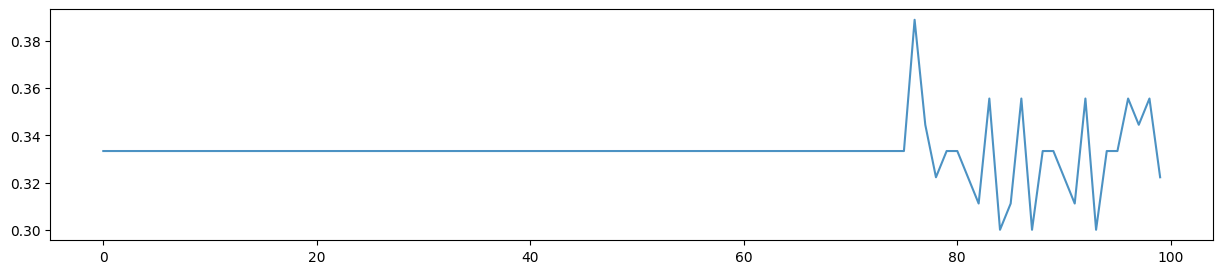

In [19]:
acc = pd.read_csv("Accuracy.csv", sep=",", skipinitialspace=True)

plt.figure(figsize=(15,3))
plt.plot(acc["epoch"], acc["train_accuracy"], label="Train Accuracy", alpha=.8)
plt.plot(acc["epoch"], acc["validation_accuracy"], label="Validation Accuracy", alpha=.8)
plt.plot(history['Accuracy'], label='K-Training accuracy', alpha=.8)
plt.plot(history['val_Accuracy'], label='K-Validation accuracy', alpha=.8)

plt.title("Train - Accuracy - Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=.3)

lss = pd.read_csv("Loss.csv", sep=",", skipinitialspace=True)

plt.figure(figsize=(15,3))
plt.plot(lss["epoch"], lss["loss"], label="loss", alpha=.8)
plt.plot(history['loss'], label='K-loss', alpha=.8)


plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("train - Loss")
plt.legend()
plt.grid(alpha=.3)

# Mostra il grafico
plt.show()

## Cuda Version

In [15]:
!nvcc -arch=sm_75 -c ../src/cudaMMul.cu -o cuda_functions.o

../src/cudaMMul.cu: In function ‘void cudaFunctionF(float*, float*, float*, int, int, int, int)’:
../src/cudaMMul.cu:147:22: warning: ‘cudaError_t cudaThreadSynchronize()’ is deprecated []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wdeprecated-declarations-Wdeprecated-declarations]8;;]
  147 |     cudaThreadSynchronize();
      |     ~~~~~~~~~~~~~~~~~^~
/usr/local/cuda/bin/../targets/x86_64-linux/include/cuda_runtime_api.h:1069:46: note: declared here
 1069 | extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
      |                                              ^~~~~~~~~~~~~~~~~~~~~
../src/cudaMMul.cu: In function ‘void cudaFunctionD(double*, double*, double*, int, int, int, int)’:
../src/cudaMMul.cu:179:22: warning: ‘cudaError_t cudaThreadSynchronize()’ is deprecated []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wdeprecated-declarations-Wdeprecated-declarations]8;;]
  179 |     cudaThreadSynchronize();

In [16]:
!g++ -c -O3 -std=c++17 -I ../include  -march=native -ffast-math amsc_nnet.cpp ../src/irisLoader.cpp ../src/cuda_network_functions.cpp ../src/ActivationFunctions.cpp  ../src/matrixProd_AVX.cpp -mavx2 -mfma -std=c++20

In [17]:
!nvcc ActivationFunctions.o cuda_functions.o matrixProd_AVX.o cuda_network_functions.o amsc_nnet.o irisLoader.o -o cuda_nnet

In [18]:
!./cuda_nnet

Building model...
Model name: myModel
Number of epochs: 100
Batch size: 16
Learning rate: 0.05
Loss function: MSE
Stop cryteria: early_stop

Input layer: 
Number of input introduced in the network: 4


Model name: myModel
-------------------------------------------------------------
Layers (type)                  Output Shape         Params #

Input (Input Layer)40

layer1 (Dense)128640

ReLu (Hidden Layer)1280

Output (Output layer)3387

sigmoid (Activation Function)30


Total params: 1027 (4 KB)
_____________________________________________________________

Model built!

Train started !  (details and results available in Train_Output.txt file)

Progress: 0%0%0%0%0%1%1%1%1%1%1%2%2%2%2%2%2%3%3%3%3%3%3%4%4%4%4%4%4%5%5%5%5%5%5%6%6%6%6%6%6%7%7%7%7%7%7%8%8%8%8%8%8%9%9%9%9%9%9%10%10%10%10%10%10%11%11%11%11%11%11%12%12%12%12%12%12%13%13%13%13%13%13%14%14%14%14%14%14%15%15%15%15%15%15%16%16%16%16%16%16%17%17%17%17%17%17%18%18%18%18%18%18%19%19%19%19%19%19%20%20%20%20%20%20%21%21%21%21%21%21%2